**Table of Contents**

- *Principal Component Analysis (PCA)*

- *t-Distributed Stochastic Neighboring Entities (t-SNE)*

- *Uniform Manifold Approximation and Projection (UMAP)*

- *K-Means Clustering*

- *Density-Based Spatial Clustering of Applications with Noise (DBSCAN)*

In [ ]:
!pip install tbb
!pip install umap-learn

In [ ]:
import warnings
import umap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score,silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

**Utillity Functions**

In [ ]:
class Utils:
  def __init__(self):
    self.mapping = {0:'t-shirt/top',1:'trouser',2:'pullover',3:'dress',4:'coat',5:'sandal',6:'shirt',7:'sneaker',8:'bag',9:'ankle boot'}

  def frequency_table(self,data):
    """
    Produce the frequency table.
    """
    self.data = data
    df_freq = pd.DataFrame(self.data.label.value_counts()).reset_index()
    df_freq.columns = ['label','frequency']
    df_freq = df_freq.sort_values(by='label')
    return df_freq

  def reshape(self,data):
    """
    Reshape the data for plotting.
    """
    self.data = data
    data_array = np.array([i.reshape(28,28) for i in np.array(self.data.iloc[:,1:])])
    return data_array

**Data Preprocessing**

In [ ]:
# Load the data
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

# Training set
X_train = train.iloc[:,1:]
y_train = train.iloc[:,:1]

# Testing set
X_test = test.iloc[:,1:]
y_test = test.iloc[:,:1]

In [ ]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Sample Data**

In [ ]:
process = Utils()
df_sample = pd.DataFrame()

for l in train['label'].unique():
  df_l = train[train.label==l].reset_index(drop=True)
  idx = np.random.randint(0,df_l.shape[0])
  df_i = df_l.iloc[idx:idx+1,:]
  df_sample = pd.concat([df_sample,df_i],axis=0)

df_sample = df_sample.reset_index(drop=True)
df_sample['label'] = df_sample['label'].map(process.mapping)

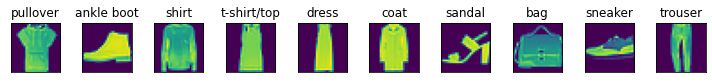

In [ ]:
sample_imgs = process.reshape(df_sample)

f,a = plt.subplots(1,10,figsize=(10,10))
for i in range(df_sample.shape[0]):
  a[i].imshow(sample_imgs[i])
  a[i].grid(False)
  a[i].set_xticks([])
  a[i].set_yticks([])
  a[i].set_title(df_sample.loc[i,'label'])
plt.tight_layout()
plt.show()

**Frequency Table**

In [ ]:
# Training data
train_freq = process.frequency_table(train)
train_freq.columns = ['label','train_freq']

# Testing data
test_freq = process.frequency_table(test)
test_freq.columns = ['label','test_freq']

df_freq = pd.merge(train_freq,test_freq,on='label',how='inner')
df_freq['text_label'] = df_freq['label'].map(process.mapping)

In [ ]:
# Frequency table
df_freq

,label,train_freq,test_freq,text_label
0,0,6000,1000,t-shirt/top
1,1,6000,1000,trouser
2,2,6000,1000,pullover
3,3,6000,1000,dress
4,4,6000,1000,coat
5,5,6000,1000,sandal
6,6,6000,1000,shirt
7,7,6000,1000,sneaker
8,8,6000,1000,bag
9,9,6000,1000,ankle boot


**Principal Component Analysis (PCA)**

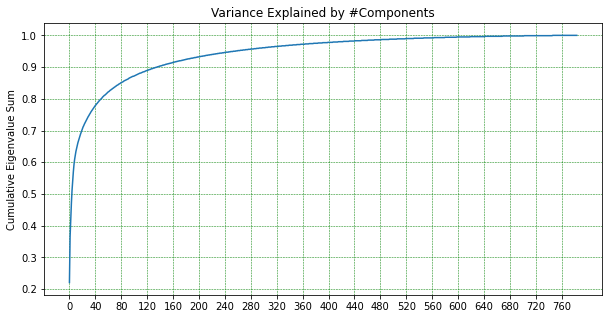

In [ ]:
# Get the cumulative principal component variance 
cov = np.cov(X_train_scaled.T) # covariance
l,v = np.linalg.eig(cov) # eigenvectors and eigenvalues
l_sort = np.sort(l)[::-1]
sort_order = np.argsort(l)[::-1]
df_loading_vecs = pd.DataFrame(v[sort_order],columns=['loading_vec_'+str(i) for i in range(len(v))]) # loading vectors
cum_var = np.round(np.cumsum(l_sort)/np.sum(l_sort),3) # variance explained 

# Visualze the outcome
plt.figure(figsize=(10,5))
plt.plot(cum_var)
plt.xticks(range(0,len(v),40))
plt.ylabel('Cumulative Eigenvalue Sum')
plt.grid(color='green',linestyle='--',linewidth=0.5)
plt.title('Variance Explained by #Components')
plt.show()

In [ ]:
# Number of components needed to explain 70%,80%,90% of variance
k70 = np.min(np.where(cum_var>0.7))+1
k80 = np.min(np.where(cum_var>0.8))+1
k90 = np.min(np.where(cum_var>0.9))+1
print('Need {}, {}, {} components to explain 70%, 80%, and 90% of variance.'.format(k70,k80,k90))

Need 21, 51, 137 components to explain 70%, 80%, and 90% of variance.


**t-Distributed Stochastic Neighboring Entities (t-SNE)**

Implementing t-SNE directly to the training set is costly. We can first reduce the dimensionality by incorporating the findings from the PCA.

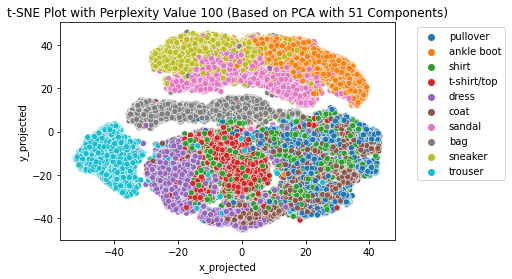

In [ ]:
# Set up a PCA and t-SNE pipeline 
pca_tsne = Pipeline([('pca',PCA(n_components=51,random_state=100)),
                     ('tsne',TSNE(n_components=2,perplexity=100,random_state=100))])

with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  df_pca_tsne = pd.DataFrame(pca_tsne.fit_transform(X_train_scaled),columns=['x_projected','y_projected'])
  df_pca_tsne = pd.concat([y_train,df_pca_tsne],axis=1)
  df_pca_tsne['text_label'] = df_pca_tsne['label'].map(process.mapping)
  sns.scatterplot(x='x_projected',y='y_projected',hue='text_label',data=df_pca_tsne)
  plt.title('t-SNE Plot with Perplexity Value 100 (Based on PCA with 51 Components)')
  plt.legend(bbox_to_anchor=(1.05,1))
  plt.show()

The t-SNE plot suggests 5 as the number of clusters.

**Uniform Manifold Approximation and Projection (UMAP)**

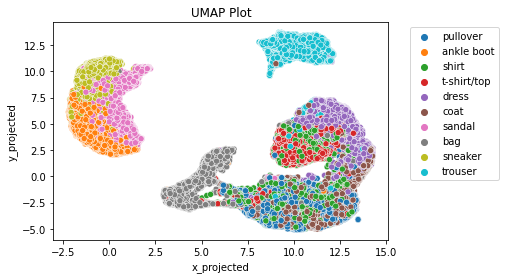

In [ ]:
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  umap = umap.UMAP(n_components=2,random_state=100)
  df_umap = pd.DataFrame(umap.fit_transform(X_train_scaled),columns=['x_projected','y_projected'])
  df_umap = pd.concat([y_train,df_umap],axis=1)
  df_umap['text_label'] = df_umap['label'].map(process.mapping)
  sns.scatterplot(x='x_projected',y='y_projected',hue='text_label',data=df_umap)
  plt.title('UMAP Plot')
  plt.legend(bbox_to_anchor=(1.05,1))
  plt.show()

UMAP is computationally less expensive than t-SNE. It is arguable that the algorithm also suggests using 4 or 5 as the number of clusters.

**K-Means**

While both t-SNE and UMAP suggest 4 or 5 as the number of clusters, we can still try to plot a elbow plot with inertia values for further investigation.

*Full Data Set*

In [ ]:
# Apply K-means with different cluster numbers directly to the data
inertias_full = []
for k in range(1,11):
  model = KMeans(n_clusters=k,random_state=100)
  model.fit(X_train_scaled)
  inertias_full.append(model.inertia_)

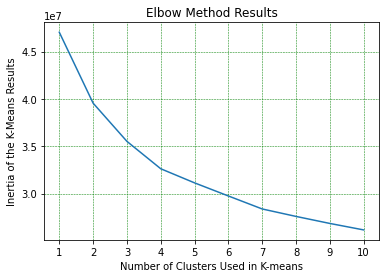

In [ ]:
# Elbow plot
plt.plot(np.array([i for i in range(1,11)]),inertias_full)
plt.xlabel('Number of Clusters Used in K-means')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Inertia of the K-Means Results')
plt.grid(color='green',linestyle='--',linewidth=0.5)
plt.title('Elbow Method Results')
plt.show()

Although the elbow plot does not display a clear candidate for the number of clusters, 4 seems to be a decent candidate considering it's close to wha the t-SNE and UMAP plots suggest.

In [ ]:
# Implement K-means with 4 clusters
model_full = KMeans(n_clusters=4,random_state=100)
model_full.fit(X_train_scaled)

KMeans(n_clusters=4, random_state=100)

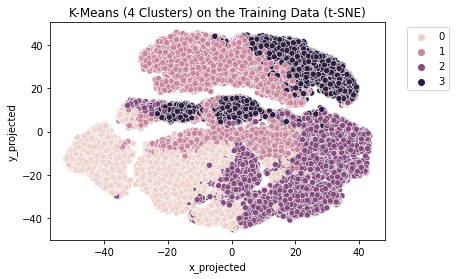

In [ ]:
# Visualize the 4-cluster K-means model output on the t-SNE plot with 2 PCA components
df_pca_tsne['predicted_label'] = model_full.labels_
sns.scatterplot(x='x_projected',y='y_projected',hue='predicted_label',data=df_pca_tsne)
plt.title('K-Means (4 Clusters) on the Training Data (t-SNE)')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

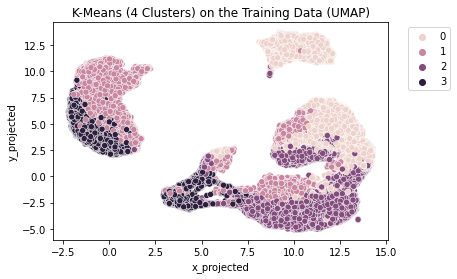

In [ ]:
# Visualize the 4-cluster K-means model output on the UMAP plot
df_umap['predicted_label'] = model_full.labels_
sns.scatterplot(x='x_projected',y='y_projected',hue='predicted_label',data=df_umap)
plt.title('K-Means (4 Clusters) on the Training Data (UMAP)')
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

From the above plots, it seems that the clustering of K-means algorithm on the full data doesn't fully agree with the clustering observed from the t-SNE and UMAP plots.

*PCA Reduced Data Set*

Next, we try to apply the K-means algorithm to a reduced data set with PCA. We opt to choose 2 as the number of components in our PCA to avoid the data set being too similar to the original set.

In [ ]:
# Apply K-means with different cluster numbers to the 2-component PCA output
pca_2 = PCA(n_components=2,random_state=100)
pca_2_output = pca_2.fit_transform(X_train_scaled)
inertias_pca_2 = []
for k in range(1,11):
  model = KMeans(n_clusters=k,random_state=100)
  model.fit(pca_2_output)
  inertias_pca_2.append(model.inertia_)

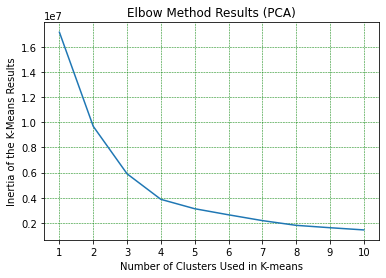

In [ ]:
# Elbow plot
plt.plot(np.array([i for i in range(1,11)]),inertias_pca_2)
plt.xlabel('Number of Clusters Used in K-means')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Inertia of the K-Means Results')
plt.grid(color='green',linestyle='--',linewidth=0.5)
plt.title('Elbow Method Results (2-Component PCA)')
plt.show()

Once again, we choose 4 as the number of clusters for the K-means algorithm.

In [ ]:
# Implement K-means with 4 clusters on the 2-component PCA output
kmeans_pca = KMeans(n_clusters=4,random_state=100)
kmeans_pca.fit(pca_2_output)

KMeans(n_clusters=4, random_state=100)

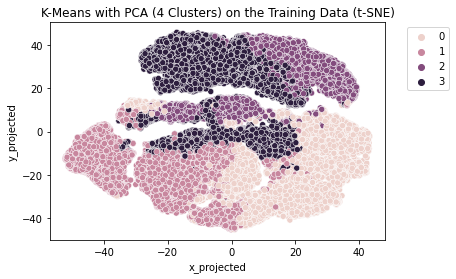

In [ ]:
# Visualize the 4-cluster K-means model output on the t-SNE plot with 2 PCA components
df_pca_tsne['predicted_label'] = kmeans_pca.labels_
sns.scatterplot(x='x_projected',y='y_projected',hue='predicted_label',data=df_pca_tsne)
plt.title('K-Means with PCA (4 Clusters) on the Training Data (t-SNE)')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

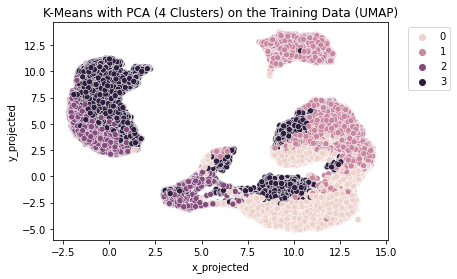

In [ ]:
# Visualize the 4-cluster K-means model output on the UMAP plot
df_umap['predicted_label'] = kmeans_pca.labels_
sns.scatterplot(x='x_projected',y='y_projected',hue='predicted_label',data=df_umap)
plt.title('K-Means with PCA (4 Clusters) on the Training Data (UMAP)')
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

The observations are similar to the ones obtained using the full data set. Note that the 2 components of PCA explains around $30\%$ of the data variance. 

*Post-Clustering Analysis*

Given the similarity, we use the K-means with PCA model for this section.

In [ ]:
# Percentage of labels in each cluster
df_pca_kmeans = y_train.copy()
df_pca_kmeans['predicted_cluster'] = kmeans_pca.labels_
df_pca_kmeans['label'] = df_pca_kmeans['label'].map(process.mapping)

percents = {}
for i in range(4):
  df_i = df_pca_kmeans[df_pca_kmeans.predicted_cluster==i]
  percents_i = []
  for l in df_pca_kmeans['label'].unique():
    percents_i.append(df_i[df_i.label==l].shape[0]/df_i.shape[0])
  percents['cluster_'+str(i)] = percents_i

df_pca_kmeans_summary = pd.DataFrame(percents)

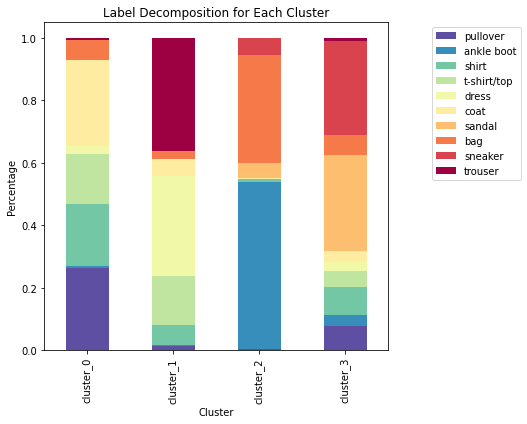

In [ ]:
# Plot the summary
df_pca_kmeans_summary.T.plot(kind='bar',stacked=True,figsize=(8,6),cmap=plt.cm.Spectral_r)
plt.title('Label Decomposition for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend([i for i in df_pca_kmeans['label'].unique()],bbox_to_anchor=(1.4,1))
plt.tight_layout()
plt.show()

- In cluster 0, we have pullover, shirt, t-shirt/top, and coat having roughly the same percentage.

- In cluster 1, we have dress and trouser as the  dominant items. 

- In cluster 2, ankle boot and bag are the dominant items.

- In cluster 3, sneaker and sandal are dominant. 

It is reasonable to assume say that the clustering has some success in grouping items with similar function/shape together. 


**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

Looking at the t-SNE plot and the UMAP plot, it's clear that the shapes of the clusters are not perfectly spherical. And it is not straightforward to decide whether to put items that look similar into separate clusters. DBSCAN could be a good algorithm to use here because 

- it doesn't require us to specify the number of clusters.

- it isn't sensitive to outliers.

- the clusters formed can be any shape.

The key parameter in DBSCAN is `eps`, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. We can use nearest neighbors to calculate the average distance between each point and its neighbor to estimate the appropriate choice of `eps`. 

*Full Data Set*

Implementing DBSCAN is demonstrated to be too computationally expensive as our Google Colab Pro session keeps crashing due to hitting the memory limit. We will instead go straight to PCA reduced data set. We use 21 as the number of components to preserve 70% of the data variance.

*PCA Reduced Data Set*

In [ ]:
# Apply K-means with different cluster numbers to the 21-component PCA output
pca_21 = PCA(n_components=21,random_state=100)
pca_21_output = pca_21.fit_transform(X_train_scaled)

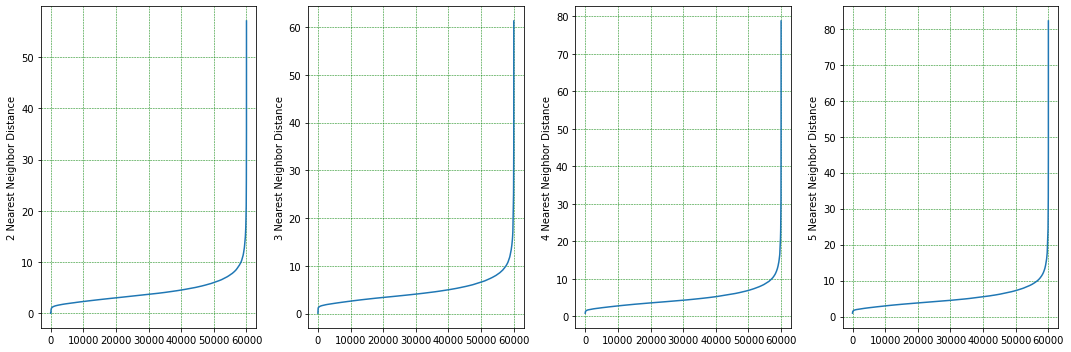

In [ ]:
# Nearest neighbors on the full data set
f,a = plt.subplots(1,4,figsize=(15,5))

for i,k in enumerate(np.arange(2,6,1)):
  neighbors = NearestNeighbors(n_neighbors=k).fit(pca_21_output)
  dists,inds = neighbors.kneighbors(pca_21_output)
  a[i].plot(np.sort(dists.T[k-1],axis=0))
  a[i].set_ylabel('{} Nearest Neighbor Distance'.format(k))
  a[i].grid(color='green',linestyle='--',linewidth=0.5)
plt.tight_layout()
plt.show()

The ideal value of `eps` is determined by the elbow of the above plot. It seems that regardless of the `n_neighbors` value, a value in the 10 to 20 range is a good candidate for `eps`. We also perform the grid search below for hyperparameter tuning.

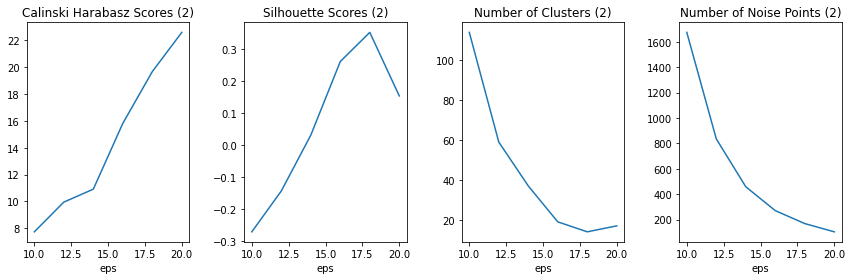

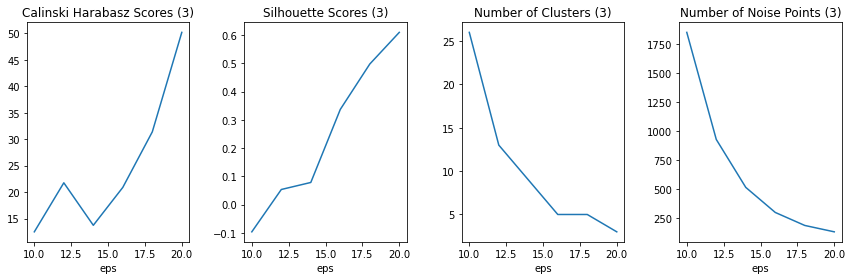

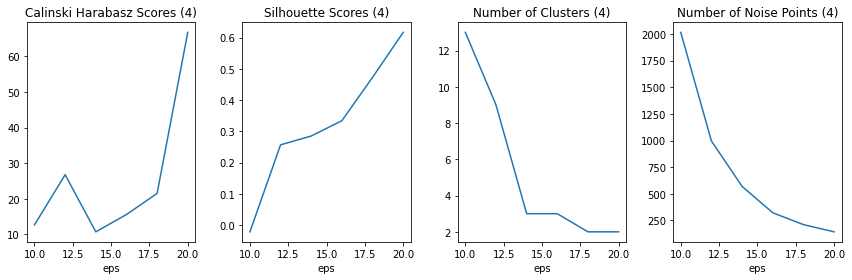

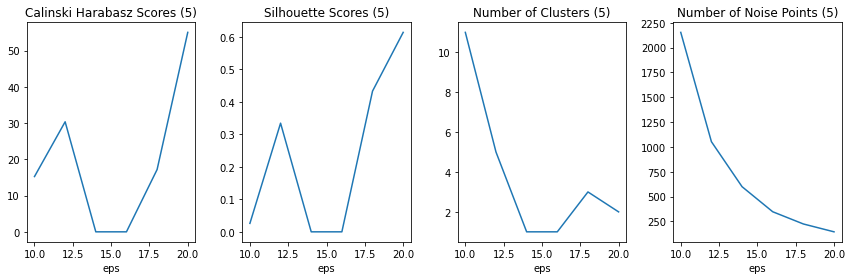

In [ ]:
# Apply DBSCAN directly to the data with different min_samples and eps values
calinski_harabasz_scores = []
silhouette_scores = []
num_clusters = []
num_noise_points = []

for minpts in np.arange(2,6,1):
  calinski_harabasz_scores = []
  silhouette_scores = []
  num_clusters = []
  num_noise_points = []

  df_dbscan = y_train.copy()

  for eps in np.arange(10,22,2):
    model = DBSCAN(eps=eps,min_samples=minpts,metric='euclidean')
    model.fit(pca_21_output)
    df_dbscan['predicted_cluster'] = model.labels_

    # Get the number of clusters
    k = df_dbscan['predicted_cluster'].nunique()-1
    num_clusters.append(k)

    # Get the number of noise points
    num_noise = df_dbscan[df_dbscan.predicted_cluster==-1].shape[0]
    num_noise_points.append(num_noise)

    # Silhouette score of the clustering
    if k>1:
      silhouette_scores.append(silhouette_score(pca_21_output[df_dbscan.predicted_cluster!=-1],
                                                df_dbscan[df_dbscan.predicted_cluster!=-1]['predicted_cluster']))
    else:
      silhouette_scores.append(0)
    
    # Calinski Harabasz scores of the clustering
    if k>1:
      calinski_harabasz_scores.append(calinski_harabasz_score(pca_21_output[df_dbscan.predicted_cluster!=-1],
                                                              df_dbscan[df_dbscan.predicted_cluster!=-1]['predicted_cluster']))
    else:
      calinski_harabasz_scores.append(0)
  
  # Plot the results
  f,a = plt.subplots(1,4,figsize=(12,4),sharex=True)
  eps = np.arange(10,22,2)
  a[0].plot(eps,calinski_harabasz_scores)
  a[1].plot(eps,silhouette_scores)
  a[2].plot(eps,num_clusters)
  a[3].plot(eps,num_noise_points)

  a[0].set_title('Calinski Harabasz Scores ({})'.format(minpts))
  a[1].set_title('Silhouette Scores ({})'.format(minpts))
  a[2].set_title('Number of Clusters ({})'.format(minpts))
  a[3].set_title('Number of Noise Points ({})'.format(minpts))

  a[0].set_xlabel('eps')
  a[1].set_xlabel('eps')
  a[2].set_xlabel('eps')
  a[3].set_xlabel('eps')

  plt.tight_layout()
  plt.show()

- We don't want the algorithm to treat too many data points as noise.

- We would like the number clusters to be reasonable.

- We want the model to have high evaluation score.

With these in mind, we choose 20 as the `eps` value as 4 as the `min_samples` value. 

In [ ]:
# Apply DBSCAN directly to the reduced data
dbscan_pca = DBSCAN(eps=20,min_samples=4,metric='euclidean')
dbscan_pca.fit(pca_21_output)

DBSCAN(eps=20, min_samples=4)

*Post-Clustering Analysis*

In [ ]:
# Percentage of labels in each cluster
df_pca_dbscan = y_train.copy()
df_pca_dbscan['predicted_cluster'] = dbscan_pca.labels_
df_pca_dbscan['label'] = df_pca_dbscan['label'].map(process.mapping)
df_pca_dbscan = df_pca_dbscan[df_pca_dbscan.predicted_cluster!=-1]

percents = {}
for i in range(2):
  df_i = df_pca_dbscan[df_pca_dbscan.predicted_cluster==i]
  percents_i = []
  for l in df_pca_dbscan['label'].unique():
    percents_i.append(df_i[df_i.label==l].shape[0]/df_i.shape[0])
  percents['cluster_'+str(i)] = percents_i

df_pca_dbscan_summary = pd.DataFrame(percents)

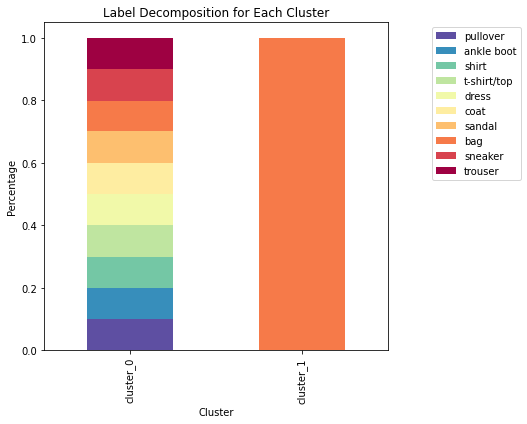

In [ ]:
# Plot the summary
df_pca_dbscan_summary.T.plot(kind='bar',stacked=True,figsize=(8,6),cmap=plt.cm.Spectral_r)
plt.title('Label Decomposition for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend([i for i in df_pca_dbscan['label'].unique()],bbox_to_anchor=(1.4,1))
plt.tight_layout()
plt.show()

It is clear that DBSCAN algorithm failed to generate meaningful clusters. It picks up a few anomolies in the bag category and put those data points in a dedicated cluster while leaving the rest together. 

We also investigate other combinations of `eps` and `min_samples`. While the number of clusters varies, those results also put most of the data points in one cluster and put a selected few anomolies from different categories in different clusters. 

One interesting finding is that DBSCAN can distinguish those anomolies rather successfully. Our hypothesis is that from the algorithm's perspective, the majority of the data points look rather similar. With this in mind, we plot the eigenvectors corresponding to the top 21 eigenvalues below.

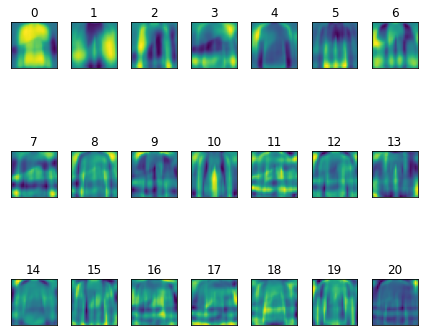

In [ ]:
# Plot the 21 eigenvectors
f,a = plt.subplots(3,7,figsize=(6,6))
for i in range(21):
  a[int(np.floor(i/7)),int(i-7*np.floor(i/7))].set_title(i)
  a[int(np.floor(i/7)),int(i-7*np.floor(i/7))].imshow(pca_21.components_[i].reshape((28,28)))
  a[int(np.floor(i/7)),int(i-7*np.floor(i/7))].set_xticks([])
  a[int(np.floor(i/7)),int(i-7*np.floor(i/7))].set_yticks([])
plt.tight_layout()
plt.show()

Notice how most of them look like a top/t-shirt. From this perspective, the data is rather homogeneous. Currently, we are not sure why K-means algorithm is able to overcome this homogeneity and generate meaningful clustering.